In [1]:
import re
import json
import os
import shutil

from datetime import datetime
import IPython.display as ipd

import numpy as np
import pandas as pd
pd.options.display.max_columns = 100
pd.options.display.max_colwidth = 200

import datasets as hfd

import transformers
print(f'transformers version: "{transformers.__version__}"')

from transformers import (
    Wav2Vec2Processor, Wav2Vec2ProcessorWithLM,
    Wav2Vec2ForCTC,
    TrainingArguments, Trainer
)

import pyctcdecode

import torch
print(torch.cuda.is_available())

transformers version: "4.17.0"
True


In [2]:
from src.data_collator import DataCollatorCTCWithPadding
from src.metrics import WerMetricWithLM, parse_w2v2_predictions_batched_with_lm

In [3]:
import logging
logging_format_str = '%(asctime)s:%(name)s:%(levelname)s:%(message)s'
logging.basicConfig(format=logging_format_str, level=logging.WARNING)
logger = logging.getLogger('STT')
logger.setLevel(level=logging.DEBUG)

In [4]:
# DATA_ROOT_DP = os.environ['DATA_HOME']
SSD_DATA_ROOT_DP = os.environ['SSD_DATA_HOME']

In [5]:
CV_PROCESSED_2_DP = f'{SSD_DATA_ROOT_DP}/datasets/cv-corpus-8.0-2022-01-19__be__processed__2'

In [6]:
ds = hfd.load_from_disk(CV_PROCESSED_2_DP)
ds

DatasetDict({
    train: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 314305
    })
    dev: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15803
    })
    test: Dataset({
        features: ['input_values', 'labels'],
        num_rows: 15801
    })
})

## read model

In [7]:
processor = Wav2Vec2Processor.from_pretrained('artifacts/processor')

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [8]:
data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [9]:
pretrained_checkpoint_dp = 'train/run_4/2022-03-31-21-50-25/checkpoint-12960/'
print(os.listdir(pretrained_checkpoint_dp))

['scheduler.pt', 'preprocessor_config.json', 'training_args.bin', 'pytorch_model.bin', 'scaler.pt', 'config.json', 'rng_state.pth', 'optimizer.pt', 'trainer_state.json']


In [10]:
# continue from checkpoint
model = Wav2Vec2ForCTC.from_pretrained(pretrained_checkpoint_dp)

In [11]:
model.to('cuda');
model.device

device(type='cuda', index=0)

## prepare processor

In [12]:
vocab = processor.tokenizer.get_vocab()
pd.Series(vocab).sort_values().to_frame().T

,|,',i,а,б,в,г,д,е,ж,з,й,к,л,м,н,о,п,р,с,т,у,ф,х,ц,ч,ш,ы,ь,э,ю,я,ё,і,ў,[UNK],[PAD],<s>,</s>
0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38


In [13]:
sorted_vocab_dict = [(char, ix) for char, ix in sorted(vocab.items(), key=lambda item: item[1])]
print(sorted_vocab_dict)

[('|', 0), ("'", 1), ('i', 2), ('а', 3), ('б', 4), ('в', 5), ('г', 6), ('д', 7), ('е', 8), ('ж', 9), ('з', 10), ('й', 11), ('к', 12), ('л', 13), ('м', 14), ('н', 15), ('о', 16), ('п', 17), ('р', 18), ('с', 19), ('т', 20), ('у', 21), ('ф', 22), ('х', 23), ('ц', 24), ('ч', 25), ('ш', 26), ('ы', 27), ('ь', 28), ('э', 29), ('ю', 30), ('я', 31), ('ё', 32), ('і', 33), ('ў', 34), ('[UNK]', 35), ('[PAD]', 36), ('<s>', 37), ('</s>', 38)]


In [14]:
lm_fp = 'artifacts/lm/cv8be_5gram.bin'

In [15]:
from pyctcdecode import build_ctcdecoder

decoder = build_ctcdecoder(
    labels=[x[0] for x in sorted_vocab_dict],
    kenlm_model_path=lm_fp,
)

2022-04-01 18:43:28,387:pyctcdecode.decoder:WARNING:Unigrams not provided and cannot be automatically determined from LM file (only arpa format). Decoding accuracy might be reduced.
2022-04-01 18:43:28,389:pyctcdecode.alphabet:WARNING:Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?
2022-04-01 18:43:28,390:pyctcdecode.language_model:WARNING:No known unigrams provided, decoding results might be a lot worse.


In [16]:
processor_with_lm = Wav2Vec2ProcessorWithLM(
    feature_extractor=processor.feature_extractor,
    tokenizer=processor.tokenizer,
    decoder=decoder
)

In [17]:
print(len(processor.tokenizer.get_vocab()))
print(sorted(processor.tokenizer.get_vocab()) == sorted(processor_with_lm.tokenizer.get_vocab()))
print(" ".join(sorted(processor_with_lm.tokenizer.get_vocab())))

39
True
' </s> <s> [PAD] [UNK] i | а б в г д е ж з й к л м н о п р с т у ф х ц ч ш ы ь э ю я ё і ў


In [18]:
print(len(processor_with_lm.decoder._alphabet.labels))
print(processor_with_lm.decoder._alphabet.labels)

39
[' ', "'", 'i', 'а', 'б', 'в', 'г', 'д', 'е', 'ж', 'з', 'й', 'к', 'л', 'м', 'н', 'о', 'п', 'р', 'с', 'т', 'у', 'ф', 'х', 'ц', 'ч', 'ш', 'ы', 'ь', 'э', 'ю', 'я', 'ё', 'і', 'ў', '⁇', '', '<s>', '</s>']


In [19]:
print(len(processor_with_lm.decoder._idx2vocab))
print(processor_with_lm.decoder._idx2vocab)

39
{0: ' ', 1: "'", 2: 'i', 3: 'а', 4: 'б', 5: 'в', 6: 'г', 7: 'д', 8: 'е', 9: 'ж', 10: 'з', 11: 'й', 12: 'к', 13: 'л', 14: 'м', 15: 'н', 16: 'о', 17: 'п', 18: 'р', 19: 'с', 20: 'т', 21: 'у', 22: 'ф', 23: 'х', 24: 'ц', 25: 'ч', 26: 'ш', 27: 'ы', 28: 'ь', 29: 'э', 30: 'ю', 31: 'я', 32: 'ё', 33: 'і', 34: 'ў', 35: '⁇', 36: '', 37: '<s>', 38: '</s>'}


## evaluate model

In [20]:
wer_metrics = WerMetricWithLM(processor_with_lm=processor_with_lm)

In [21]:
training_args = TrainingArguments(
    output_dir='eval_output',
    per_device_eval_batch_size=16,
)

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=wer_metrics.compute_metrics,
    tokenizer=processor.feature_extractor,
)

### dev set

In [ ]:
pred_out = trainer.predict(ds['dev'])

In [38]:
pred_out.metrics

{'test_loss': 0.11704583466053009,
 'test_wer': 0.11524848023110011,
 'test_runtime': 484.7892,
 'test_samples_per_second': 32.598,
 'test_steps_per_second': 0.681}

In [39]:
print(f"WER on Dev set using Acoustic Model + Language model: {pred_out.metrics['test_wer'] :.3f}")

WER on Dev set using Acoustic Model + Language model: 0.115


### test set

In [ ]:
pred_out = trainer.predict(ds['test'])

In [23]:
pred_out.metrics

{'test_loss': 0.12578321993350983,
 'test_wer': 0.12350774109307965,
 'test_runtime': 544.7038,
 'test_samples_per_second': 29.008,
 'test_steps_per_second': 0.606}

In [24]:
print(f"WER on Test set using Acoustic Model + Language model: {pred_out.metrics['test_wer'] :.3f}")

WER on Test set using Acoustic Model + Language model: 0.124


### examples of model predictions

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.1);

In [26]:
parsed_preds = parse_w2v2_predictions_batched_with_lm(pred_out, processor_with_lm=processor_with_lm)

In [27]:
df_results = pd.DataFrame(parsed_preds)[['text', 'pred_text']]
print(df_results.shape)

df_results['success'] = (df_results['text'] == df_results['pred_text']).astype('int')
df_results['wer'] = df_results.apply(
    lambda row: 
    wer_metrics.wer_metric.compute(
        predictions=[row['pred_text']],
        references=[row['text']]
    ),
    axis=1
)

df_results.head()

(15801, 2)


,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.000000
1,быў разбураны пры вызваленні горада ад нямецкафашысцкіх захопнікаў,быў разбураны пры вызваленні горада ад нямецкую фашысцкіх захопнікаў,0,0.250000
2,далейшае супрацоўніцтва паміж нямецкім і савецкім прыняло форму абмену польскіх ваеннапалонных,далейшы супрацоўніцтва між нямецкім савецкім пыняафораму абмену польскіх дваеннапогам,0,0.545455
3,цвіценне працягваецца з мая да позняй восені,цвіценне працягваецца з мая да позняй восені,1,0.000000
4,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,таксама пройдзе канферэнцыя фестываль і мастацкая выстава,1,0.000000


In [28]:
success_stats = df_results['success'].value_counts(dropna=False, normalize=True)
success_stats = success_stats.to_frame('fraction').join(
    df_results['success'].value_counts(dropna=False).rename('abs')
)
success_stats

,fraction,abs
1,0.522688,8259
0,0.477312,7542


In [31]:
print(f'Rate of fully recognized clips from Test set using Acoustic Model only: '
      f"{success_stats.loc[1, 'fraction'] :.3%}")

Rate of fully recognized clips from Test set using Acoustic Model only: 52.269%


In [32]:
df_results.sort_values('wer', ascending=False).head()

,text,pred_text,success,wer
8877,дрэвы маюць гладкую светлашэрую кару,трэба мачвадкую свет па шэрую карону,0,1.2
55,нешматлікія насарогі гепарды жырафы пітоны,жмалілянапымане з парнымі адганзаю ступон,0,1.0
4902,і госці шчыра весяліліся,і вось ці шчырымі сяліліся,0,1.0
9043,па лесе ішоў сабака,алеся ішоў у сабак,0,1.0
7458,падзею можна назваць знакавай,падзел мушу назваць на хвоі,0,1.0


In [33]:
df_results.sort_values('wer', ascending=True).head()

,text,pred_text,success,wer
0,і на гэтым кірунку нас чакаюць вялікія складанасці,і на гэтым кірунку нас чакаюць вялікія складанасці,1,0.0
12698,сваім узнікненнем горад абавязаны збегу акалічнасцей,сваім узнікненнем горад абавязаны збегу акалічнасцей,1,0.0
6832,дзейнічала школа царкоўнай граматы капліца хлебазапасны магазін,дзейнічала школа царкоўнай граматы капліца хлебазапасны магазін,1,0.0
6834,коні ўзвіліся на дыбкі ад раптоўнага страху,коні ўзвіліся на дыбкі ад раптоўнага страху,1,0.0
12695,з'яўляецца адным з найстарэйшых дзейных прадпрыемстваў і найстарэйшым манетным дваром у свеце,з'яўляецца адным з найстарэйшых дзейных прадпрыемстваў і найстарэйшым манетным дваром у свеце,1,0.0


In [34]:
df_results.sort_values('wer', ascending=True).sample(5)

,text,pred_text,success,wer
2665,але пакуль краіна сама не захоча каб я паехала я не паеду,але пакуль краіна сама не захоча каб я паехала я не паеду,1,0.000000
8490,у канцы сезона стаў з'яўляцца ў стартавым складзе на пазіцыі цэнтральнага нападніка,у канцы сезона стаў з'яўляцца ў стартавым складзе на пазіцыі цэнтральнага нападніка,1,0.000000
4455,яны апранутыя ў хітоны і плашчы і маюць ярка афарбаваныя вуалі на галаве,ямы апранутыя ў хітоны плашчы і маюць ярка афарбаваныя ў але на галаве,0,0.307692
2980,у нас была яе персанальная выстава,у нас была персанальная выстава,0,0.166667
1282,я вяду дзённікі усё падлічваю,я вяду дзённікі усё падлічваю,1,0.000000


In [35]:
df_results.iloc[[12, 9532, 9533,12305]]

,text,pred_text,success,wer
12,толькі ў раёне таксама нашы людзі вясковыя,толькі ў раёне таксама нашы людзі вясковыя,1,0.0
9532,у яго нават ёсць сольныя выступы,у яго нават ёсць сольныя выступы,1,0.0
9533,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,на ўзвышшы што ў цэнтры пляцоўкі стаяла абарончая вежа,1,0.0
12305,шлюбам папярэднічалі перагаворы паміж сем'ямі,шлюбам папярэднічалі перагаворы паміж сем'ямі,1,0.0


### wer stats for test set items

count    15801.000000
mean         0.119767
std          0.166523
min          0.000000
25%          0.000000
50%          0.000000
75%          0.200000
max          1.200000
Name: wer, dtype: float64

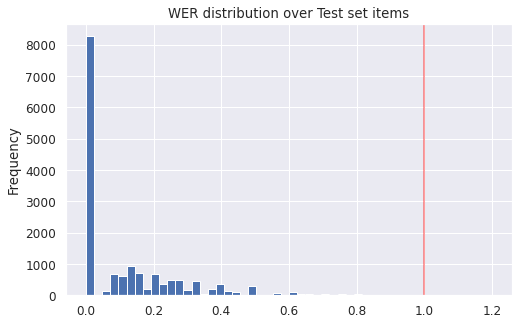

In [36]:
display(df_results['wer'].describe())

df_results['wer'].plot.hist(bins=50, figsize=(8, 5));
plt.title('WER distribution over Test set items');
plt.axvline(1, color='red', alpha=0.5);